# Modelling
In this notebook we will explore the data and build our models

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels as sm
import statsmodels.formula.api as smf

We will focus on the sale_price first, since it contains much more data

In [40]:
sale_data = pd.read_csv("data/clean_data_sell.csv")
sale_data

,property_code,property_type,property_subtype,sale_price,bedrooms,bathrooms,parking_spaces,area_util,area_total,condominium_fee,...,has_sauna,has_party_room,has_sports_court,has_24h_security,has_laundry,has_closet,has_office,has_pantry,size_category,amenity_score
0,84981-S,Casa,Padrão,298000.0,2,1,2,87.0,125.0,0.0,...,False,False,False,False,True,False,False,False,medium,0
1,84976-S,Casa,Padrão,630000.0,2,2,2,206.0,229.0,0.0,...,False,False,False,False,True,False,False,True,extra_large,0
2,84968-S,Casa,Casa de Condomínio,235000.0,3,1,2,60.0,100.0,215.0,...,False,True,False,True,True,False,False,False,medium,4
3,84962-S,Casa,Padrão,330000.0,2,2,2,121.0,162.0,0.0,...,False,False,False,False,True,False,False,False,large,0
4,84930-S,Casa,Casa de Condomínio,1192000.0,3,1,8,246.0,1022.0,270.0,...,False,False,False,False,True,True,False,True,extra_large,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3872,550-S,Apartamento,Padrão,230000.0,1,1,1,45.0,45.0,172.0,...,False,False,False,False,True,False,False,False,small,0
3873,376-S,Casa,Padrão,1000000.0,3,1,2,288.0,190.0,0.0,...,False,False,False,False,True,False,True,False,extra_large,0
3874,224-S,Casa,Padrão,750000.0,3,1,2,158.0,250.0,0.0,...,False,False,False,False,True,False,False,False,large,0
3875,162-S,Casa,Padrão,446809.0,3,2,2,160.0,170.0,0.0,...,False,False,False,False,True,False,False,False,large,0


## Exploratory data analysis

In [41]:
exp_df = sale_data.drop(columns=["property_code", 'property_subtype']) # Id and a hard to use variable (hierarchichal)
exp_df["property_type"] = exp_df["property_type"].astype("category")
exp_df.describe()

,sale_price,bedrooms,bathrooms,parking_spaces,area_util,area_total,condominium_fee,amenity_score
count,3.877000e+03,3877.000000,3877.000000,3877.000000,3877.000000,3.877000e+03,3877.000000,3877.000000
mean,5.393987e+05,2.519216,1.278050,1.983234,149.387413,6.306995e+02,148.165592,0.636833
std,4.835941e+05,0.818677,0.637709,1.406706,744.598901,2.653992e+04,260.373117,1.363752
min,6.000000e+04,0.000000,0.000000,0.000000,11.000000,0.000000e+00,0.000000,0.000000
25%,2.700000e+05,2.000000,1.000000,1.000000,60.000000,6.600000e+01,0.000000,0.000000
50%,3.800000e+05,2.000000,1.000000,2.000000,109.000000,1.500000e+02,0.000000,0.000000
75%,6.220000e+05,3.000000,1.000000,2.000000,179.000000,2.500000e+02,259.000000,0.000000
max,6.000000e+06,12.000000,9.000000,15.000000,45000.000000,1.652641e+06,2796.000000,6.000000


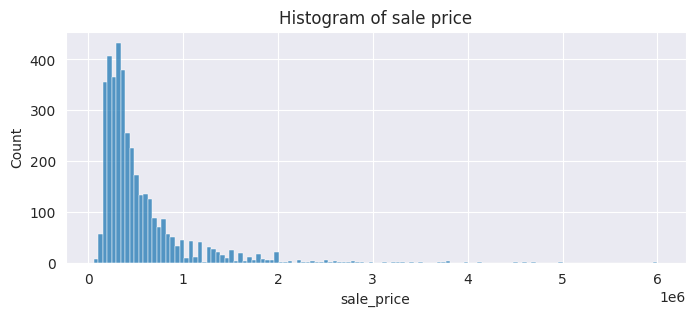

In [42]:
# Distribution of prices
fig, ax = plt.subplots(figsize=(8,3))
grid = sns.histplot(exp_df, x = "sale_price", ax = ax)
ax.set_title("Histogram of sale price")
plt.show()

Positive and right skewed

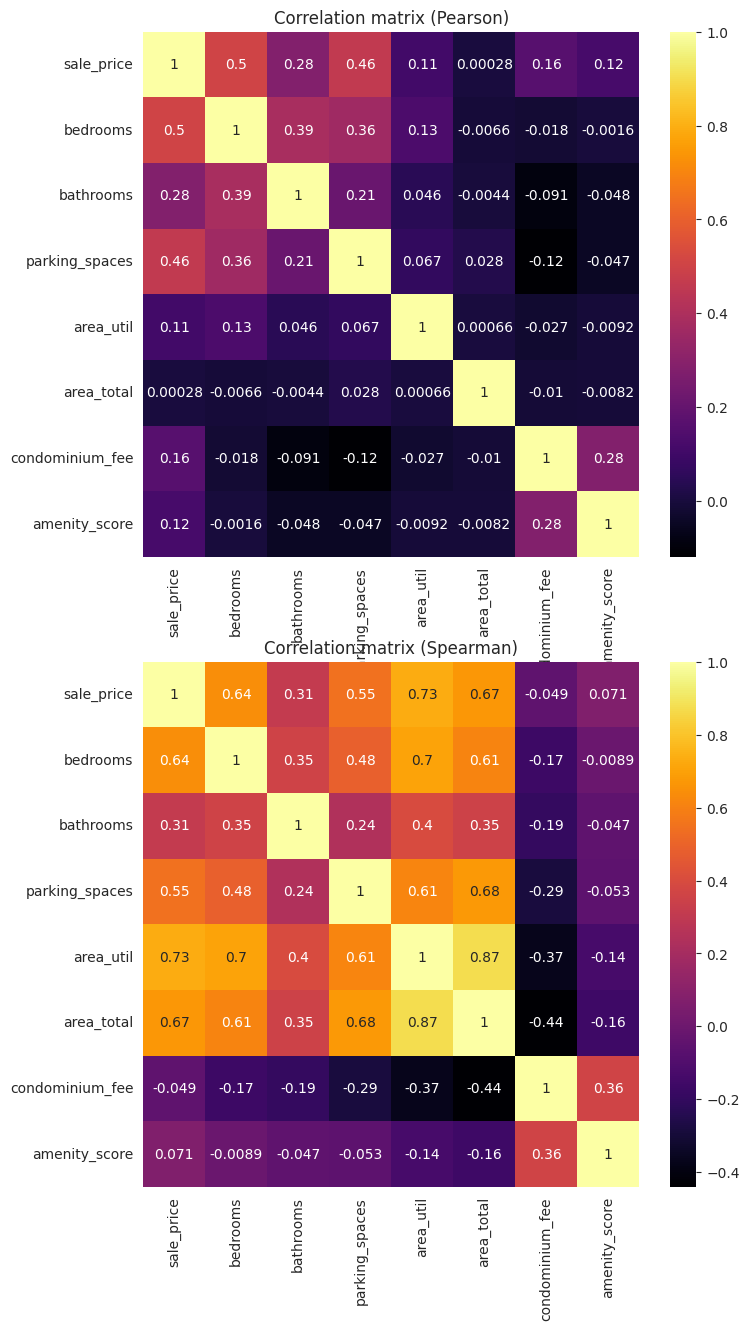

In [43]:
# Correlation heatmap for
numeric_df : pd.DataFrame = exp_df.select_dtypes(include = "number")
pearson = numeric_df.corr()
fig, axes = plt.subplots(2, 1, figsize=(8,15))
sns.heatmap(pearson, annot=True, cmap="inferno", ax = axes[0])
axes[0].set_title("Correlation matrix (Pearson)")
spearman = numeric_df.corr("spearman")
sns.heatmap(spearman, annot=True, cmap="inferno", ax = axes[1])
axes[1].set_title("Correlation matrix (Spearman)")
plt.show()

In the numerical variables, the number of bedrooms and parking spots share the highest correlation to the sale price. Between variables, there is no high correlation, so likely no multicolinearity. With spearman coef, area measures have high correlatiuon too, and high correlation between them, probably good to choose only one.

[(0.0, 3000000.0)]

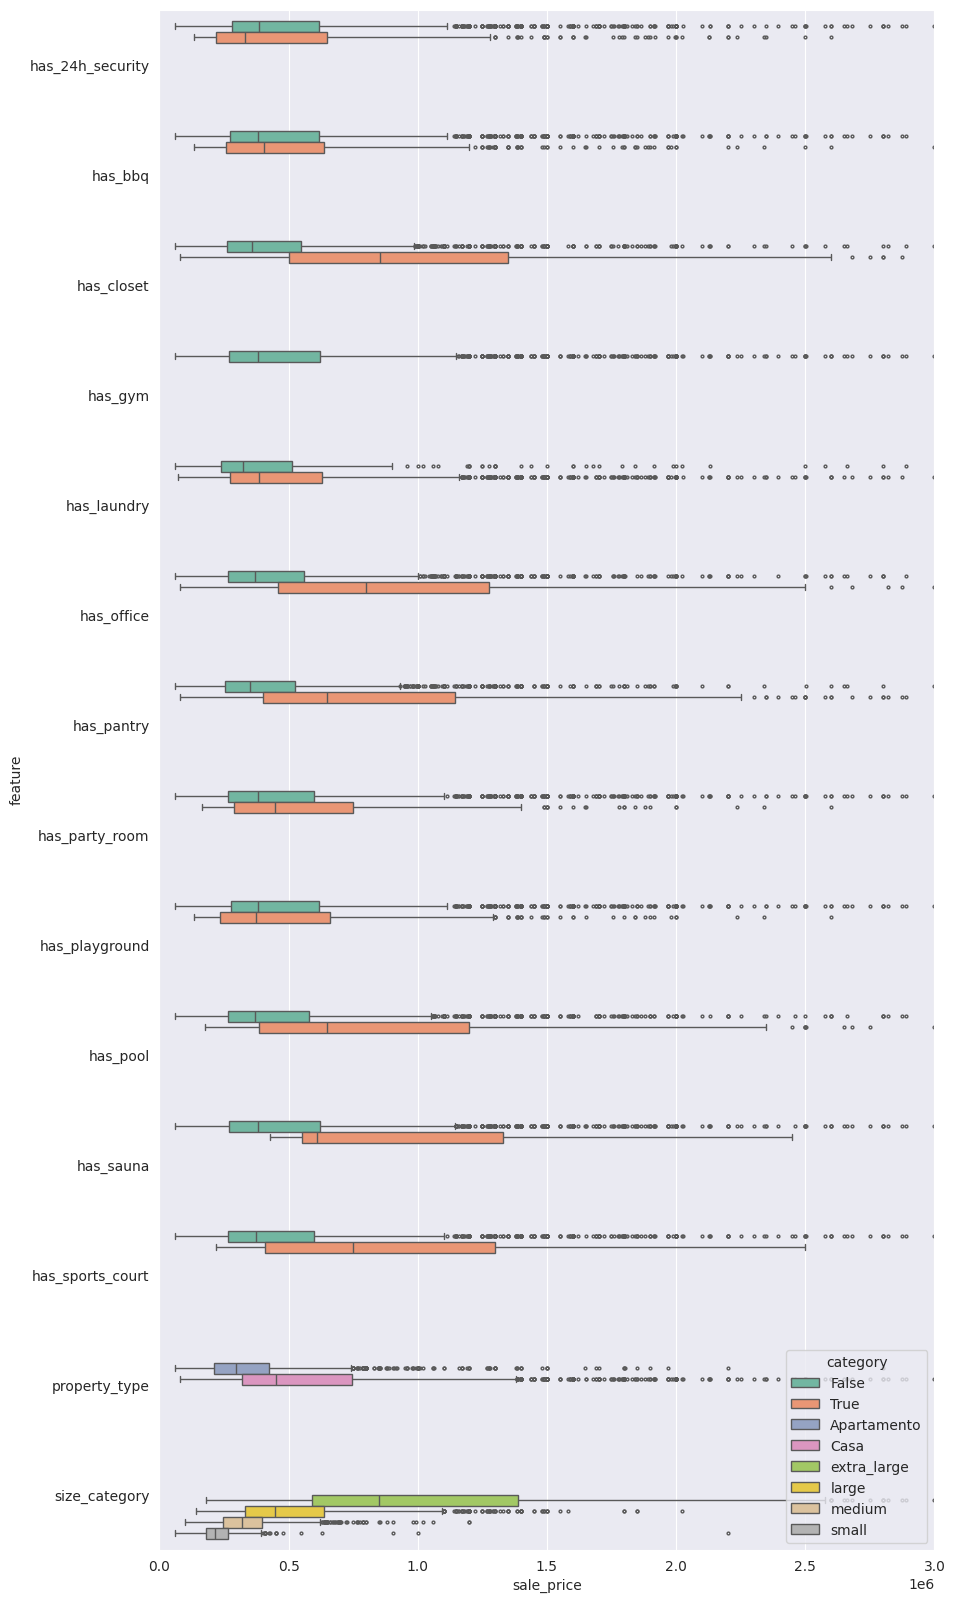

In [44]:
# Categorical variables
id_cols = ['sale_price']                      # the numeric target
cat_cols = exp_df.select_dtypes(include=['bool', 'category', 'object']).columns

fig, ax = plt.subplots(figsize=(10,20))

tidy = (exp_df.melt(id_vars=id_cols,
                value_vars=cat_cols,
                var_name='feature',
                value_name='category')
          .sort_values(['feature', 'category']))

# ------------------------------------------------------------------
# 2. plot: x = sale_price, y = feature, hue = category
# ------------------------------------------------------------------
sns.boxplot(data=tidy,
            x='sale_price',
            y='feature',
            hue='category',
            palette='Set2',
            fliersize=2,
            ax=ax)

ax.set(xlim=(0, 3e6))

We can observe that some columns affect significantly the sale price, like:
- closets
- office
- pantry
- pool
- sports court
- property type
- size category (may be highly correlated to area_total/util)

Verifiy and observe correlations

[(0.0, 1000.0)]

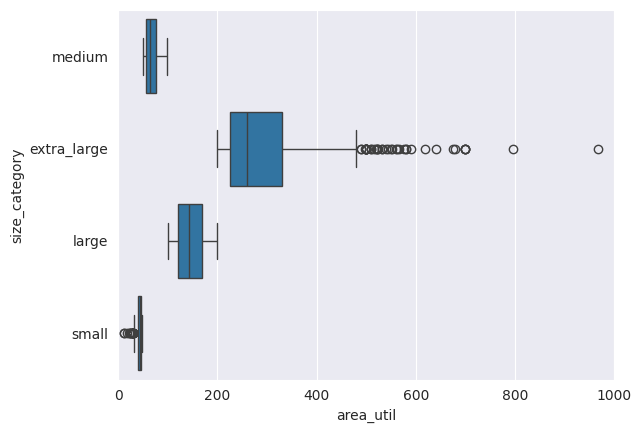

In [45]:
# Observing the relation between size_category and area
size_df = exp_df[["area_util", "size_category"]]
ax = sns.boxplot(size_df, x = "area_util", y = "size_category")
ax.set(xlim=(0, 1000))

Size category is a derived feature from area_util, so 2 of the 3 (area_total, area_util, size_category) should be removed, as not to introduce multicolinearity. Another approach is to use ridge regression. It is best to remove size_category anyway.

[None]

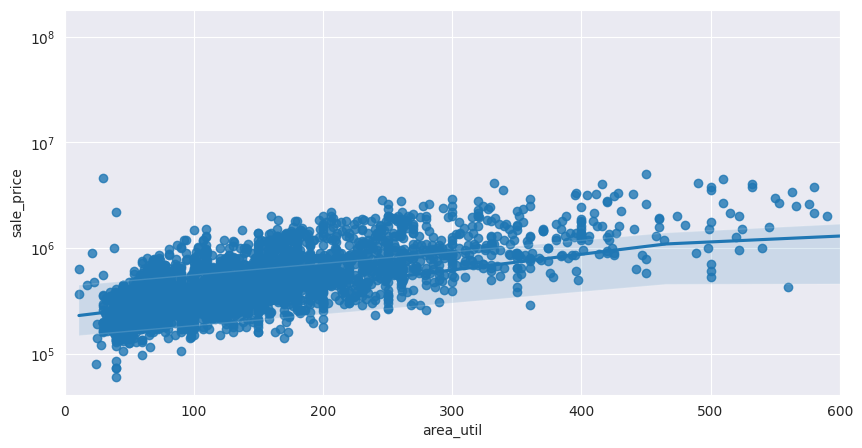

In [46]:
# Verify the shape of the correlation between area and price
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.regplot(exp_df, x = "area_util", y = "sale_price", ax = ax, robust=True)
ax.set(xlim=(0, 600))
ax.set(yscale="log")

We se a nice "linear "relationship in the loglog plot above (power law indicator), we shall use a linear model to get the slope/power. Also, in a first view, we find there are several houses with 1/2/etc meters of area (makes no sense), some with little area_total, some with a bigger area_total. Changes have been made to the data cleaning script as to consider this step

In [47]:
# linear model
reg_data = pd.DataFrame({
    "area": exp_df["area_util"],
    "price" : exp_df["sale_price"]
}).query("area < 800")

sq = lambda x : x**2
cube = lambda x : x**3
# 2nd order polynomial
model_2 = smf.ols("price ~ area + sq(area)", data=reg_data).fit()
# 3rd order polynomial
model_3 = smf.ols("price ~ area + sq(area) + cube(area)", data=reg_data).fit()
# Equivalent to exponential scaling
model_exp = smf.ols("np.log(price) ~ area", data=reg_data).fit()
print(f"{model_2.mse_model:e}")
model_2.summary()



2.319806e+14


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     2034.
Date:                Fri, 21 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:32:13   Log-Likelihood:                -54797.
No. Observations:                3873   AIC:                         1.096e+05
Df Residuals:                    3870   BIC:                         1.096e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.639e+05   1.37e+04     11.962      0.000    1.37e+05    1.91e+05
area        2131.5303    150.218     14.190      0.000    1837.016    2426.045
sq(area)       3.2141      0.317     10.128      0.000       2.592       3.836
==============================================================================
Omnibus:                     2381.254   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62147.970
Skew:                           2.468   Prob(JB):                         0.00
Kurtosis:                      21.993   Cond. No.                     1.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
print(f"{model_3.mse_model:e}")
model_3.summary()

1.548921e+14


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     1360.
Date:                Fri, 21 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:32:13   Log-Likelihood:                -54794.
No. Observations:                3873   AIC:                         1.096e+05
Df Residuals:                    3869   BIC:                         1.096e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.008e+05   2.01e+04      9.983      0.000    1.61e+05     2.4e+05
area        1385.0012    333.604      4.152      0.000     730.945    2039.057
sq(area)       6.6600      1.411      4.719      0.000       3.893       9.427
cube(area)    -0.0040      0.002     -2.506      0.012      -0.007      -0.001
==============================================================================
Omnibus:                     2374.262   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            60667.473
Skew:                           2.465   Prob(JB):                         0.00
Kurtosis:                      21.752   Cond. No.                     9.36e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.36e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
print(f"{model_exp.mse_model:e}")
model_exp.summary()

8.363608e+02


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     4359.
Date:                Fri, 21 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:32:13   Log-Likelihood:                -2297.7
No. Observations:                3873   AIC:                             4599.
Df Residuals:                    3871   BIC:                             4612.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3116      0.012   1018.823      0.000      12.288      12.335
area           0.0048    7.3e-05     66.020      0.000       0.005       0.005
==============================================================================
Omnibus:                      135.838   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.568
Skew:                           0.352   Prob(JB):                     5.63e-43
Kurtosis:                       3.842   Cond. No.                         284.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that the AIC is significantly smaller for the exponential smaller, the R2 is also bigger. The MSE is not comparable directly, but there are several orders of magnitude between them. Therefore, we will use area in its exponential form